<h1>WFA for $B_{LOS}$</h1>

This is a jupyter notebook that reads the output from RH runs and calculates LOS component of magnetic field using the WFA. We will use the equation for the weak field approximation for the line of sight component of the magnetic field: 

>$ V = -C B_{LOS} \frac{\partial I}{\partial \lambda}$


where:

>$C = 4.6686^{-13}* \lambda_0^2 * g_{eff}$

where $\lambda$ is in Angstroms, and, for Ca II 8542 Ang 

>$\lambda_0 = 8542.0857$ Ang 

>$g_{eff} = 1.10$ 


In [1]:
# First some imports
import matplotlib.pyplot as plt
import rhanalyze
import numpy as np
from rhanalyze.rhatmos import input_atmos
import glob
from numpy.polynomial import polynomial as P

In [2]:
# and some styling
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'large',
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
pylab.rcParams.update(params)


In [3]:
# Some constants for the Ca II 8542 spectral line
lam0 = 8542.09  # central wavelength in Angs
geff = 1.10     # Effective Lande factor
C = 4.6686e-13 * lam0**2. * geff   ## For wavelength in Angs

# choose a wavelength to evaluate the local continuum (in Angs)
wl_cont = 8530.0

<h1>Repetition for strong field cases </h1>

Now take synthetic spectra from a FALC atmosphere with constant vertical magnetic fields of 1000, 2000, 3000, 4000, 5000 G and repeat the WFA exercise. Just by looking at the Stokes I and V spectra, you'll be able to tell when they are no longer in the weak field regime.

In [4]:
# names of the RH output directories we want to read
rhoutputs = glob.glob('../rhf1d/run_sBlos*G_000')
rhoutputs.sort()
print(rhoutputs)



['../rhf1d/run_sBlos_1000G_000', '../rhf1d/run_sBlos_2000G_000', '../rhf1d/run_sBlos_3000G_000', '../rhf1d/run_sBlos_4000G_000', '../rhf1d/run_sBlos_5000G_000']


<h1> Are we in the weak field regime?</h1>

Let's see how $\frac{\bar g \Delta\lambda_B}{\Delta\lambda_D}$ varies as a function of height and magnetic field strength. Where:

$\bar g \Delta\lambda_B = 4.67 \cdot 10^{-13} \bar g \lambda_0^2 B$

$\Delta\lambda_D = \lambda_0/c \sqrt{\frac{2 K_B T}{\mu M_A}+\xi^2}$

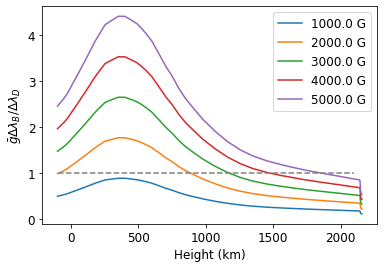

In [6]:
c = 3e8 #speed of light in m/s
mu = 40.078 # atomic weight of calcium
M = 1.66e-27 # kg (atomic mass unit)
Kb = 1.38E-23 # m^2 kg s^-2 K^-1 (Boltzmann constant)
KM_TO_M = 1e3
#dir(falc.atmos)
fig, ax = plt.subplots(figsize = (6,4))
for Brun in rhoutputs:
    # Read the input atmospheres from RH's output directory
    falc = rhanalyze.rhout(Brun) 
    Bvalue = falc.atmos.B[0]*1e4
    height = falc.geometry.height/ KM_TO_M
    Doppler = lam0/c * np.sqrt(2. * Kb * falc.atmos.T/mu/M + falc.atmos.vturb**2.)
    Zeeman = 4.67 * 1e-13 * geff * lam0**2. * falc.atmos.B*1e4 # (convert B to gauss)
    ax.plot(falc.geometry.height/ KM_TO_M, Zeeman/Doppler, label=str(Bvalue)+' G')
    
ax.plot(((-100,2100)),((1,1)), linestyle='--', color ='grey')
ax.set_xlabel('Height (km)')
ax.set_ylabel(r'$\bar g \Delta\lambda_B / \Delta\lambda_D$')
ax.legend()

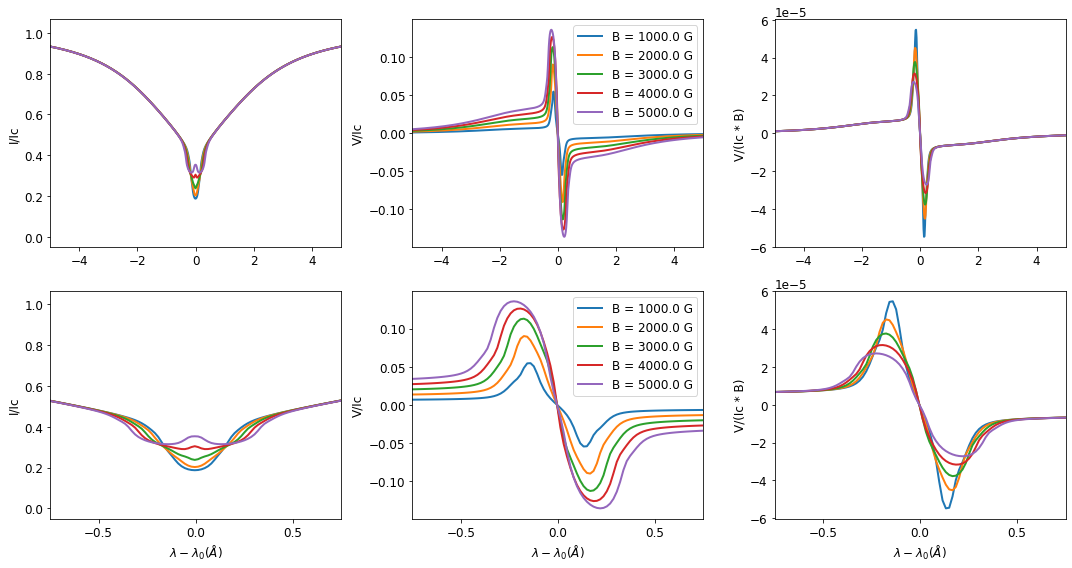

In [12]:
# Read each output directory and plot the Stokes I and V spectra


fig, ax = plt.subplots(2,3, figsize = (15, 8))
for kk in range(2):
    ax[kk,0].set_ylabel('I/Ic')
    ax[kk,1].set_ylabel('V/Ic')
    ax[kk,2].set_ylabel('V/(Ic * B)')

for jj in range(3):
    ax[1,jj].set_xlabel(r'$\lambda -\lambda_0 (\AA)$')
    ax[1,jj].set_xlim(-0.75, 0.75)
    ax[0,jj].set_xlim(-5, 5)
    ax[1,jj].locator_params(axis="x", nbins=4)

for Brun in rhoutputs:
    falc = rhanalyze.rhout(Brun) 
    # get model magnetic field value
    Bvalue = falc.atmos.B[0]*1e4 #convert from Tesla to Gauss     
    lam = falc.spectrum.waves*10.
    idx_cont = (np.abs(lam - wl_cont)).argmin()
    I = falc.rays[0].I
    Icont = I[idx_cont]

# Plot the Stokes I and Stokes V as a function of wavelength
    ax[0,0].plot(lam-lam0, falc.rays[0].I/Icont, label='B = '+str(Bvalue)+' G', linewidth=2.0)
    ax[0,1].plot(lam-lam0, falc.rays[0].V/Icont, linewidth=2.0 , label='B = '+str(Bvalue)+' G')    
    ax[0,2].plot(lam-lam0, falc.rays[0].V/Icont/Bvalue, linewidth=2.0, label='B = '+str(Bvalue)+' G') 
    ax[1,0].plot(lam-lam0, falc.rays[0].I/Icont, label='B = '+str(Bvalue)+' G', linewidth=2.0)
    ax[1,1].plot(lam-lam0, falc.rays[0].V/Icont, linewidth=2.0 , label='B = '+str(Bvalue)+' G')    
    ax[1,2].plot(lam-lam0, falc.rays[0].V/Icont/Bvalue, linewidth=2.0, label='B = '+str(Bvalue)+' G') 
ax[0,1].legend()
#ax[1,1].legend()
plt.tight_layout()

<h2>Calculate $B_{LOS}$ using the WFA</h2>

Following exactly the same method as before, we will try to calculate $B_{LOS}$ using the WFA. 
How well does the derivative of Stokes I fit the Stokes V signal?

-- Bmodel = 1000.0 G
       Bfit  = 975.8 Gauss, with intercept = 6.060786621856095e-05
       Error = -2.42%
-- Bmodel = 2000.0 G
       Bfit  = 2078.6 Gauss, with intercept = 0.00060180930062433
       Error = 3.93%
-- Bmodel = 3000.0 G
       Bfit  = 3404.7 Gauss, with intercept = 0.0015681342135062198
       Error = 13.49%
-- Bmodel = 4000.0 G
       Bfit  = 4336.9 Gauss, with intercept = 0.004616897592401581
       Error = 8.42%
-- Bmodel = 5000.0 G
       Bfit  = 2321.8 Gauss, with intercept = -0.003059722702797162
       Error = -53.56%


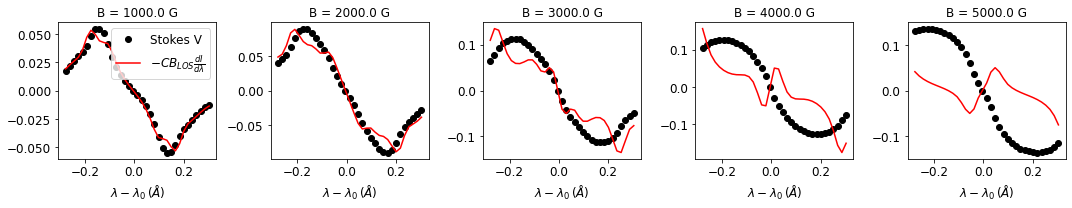

In [9]:
# wide range around line center
wl1 = 8541.01
wl2 = 8543.01
# line core only
wl1 = 8541.8
wl2 = 8542.4


fig, ax = plt.subplots(1,5, figsize = (15, 3))

for Brun in rhoutputs:    
    # Read the output from each RH run directory into the falc variable 
    falc = rhanalyze.rhout(Brun) 
    Bvalue = falc.atmos.B[0]*1e4
    lam = falc.spectrum.waves *10 # convert to Angs
    # Find wavelenght index for continuum wavelength
    idx_cont = (np.abs(lam - wl_cont)).argmin()
    I = falc.rays[0].I
    Icont = I[idx_cont]
    I = I/Icont
    V = falc.rays[0].V /Icont
    
    # derivative of I with respect to wavelength. 
    # We calculate it over the entire wavelength grid and then cut out the spectral line 
    # to avoid edge-effects from the derivative
    dIdlam = np.gradient(I, lam)

    # Cut out wavelength range around Ca II 8542
    indlam = np.argwhere(np.logical_and(lam>=wl1, lam<=wl2))  
    Vline = np.squeeze(V[indlam])
    dIdlam_line = np.squeeze(dIdlam[indlam])
    lam_line = np.squeeze(lam[indlam])
    
    
    # Calculate Blos
    # Perform a linear fit of Stokes V to -C*dI/dlam to obtain Blos

    Bfit = P.polyfit(-C*dIdlam_line, Vline, 1)
    print('-- Bmodel = '+str(Bvalue)+' G' )
    print('       Bfit  = ' +format(Bfit[1], '5.1f') + ' Gauss, with intercept = '+str(Bfit[0]))  
    print('       Error = '+ format((Bfit[1]-Bvalue)/Bvalue*100, '3.2f')+ "%")
    
    # plot Stokes V and overplot dI/dlam scaled with C and Blos
    ax[int(Bvalue/1000-1)].plot(lam_line - lam0, Vline, 'ko', label='Stokes V')
    ax[int(Bvalue/1000-1)].plot(lam_line - lam0, -Bfit[1]*C*dIdlam_line, 'r-', label=r'$-C B_{LOS} \frac{dI}{d\lambda}$') 
    ax[int(Bvalue/1000-1)].set_title('B = '+str(Bvalue)+' G')
    ax[int(Bvalue/1000-1)].set_xlabel(r'$\lambda - \lambda_0\, (\AA) $')
ax[0].legend()
plt.tight_layout()